<a href="https://colab.research.google.com/github/corralem/MITFutureMakers/blob/main/SarcasmDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

from sklearn.preprocessing import LabelBinarizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf



# Basic Libraries

import numpy as np
import pandas as pd

#Visuals

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff

#NLP tasks

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer  
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS


#DL Tasks

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,GlobalAvgPool1D,Dense,Dropout,Bidirectional,LSTM,GRU
import tensorflow as tf

#ML Tasks

from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBClassifier,XGBRFRegressor,XGBRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression,SGDRegressor
from sklearn.svm import SVC,SVR
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [4]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


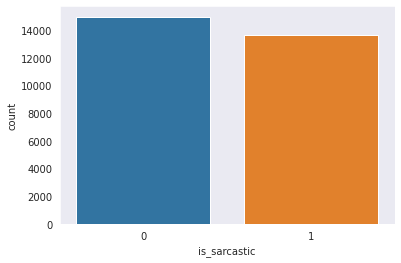

In [8]:
#Visualizing if the data is evenly dispersed 
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [10]:
#Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

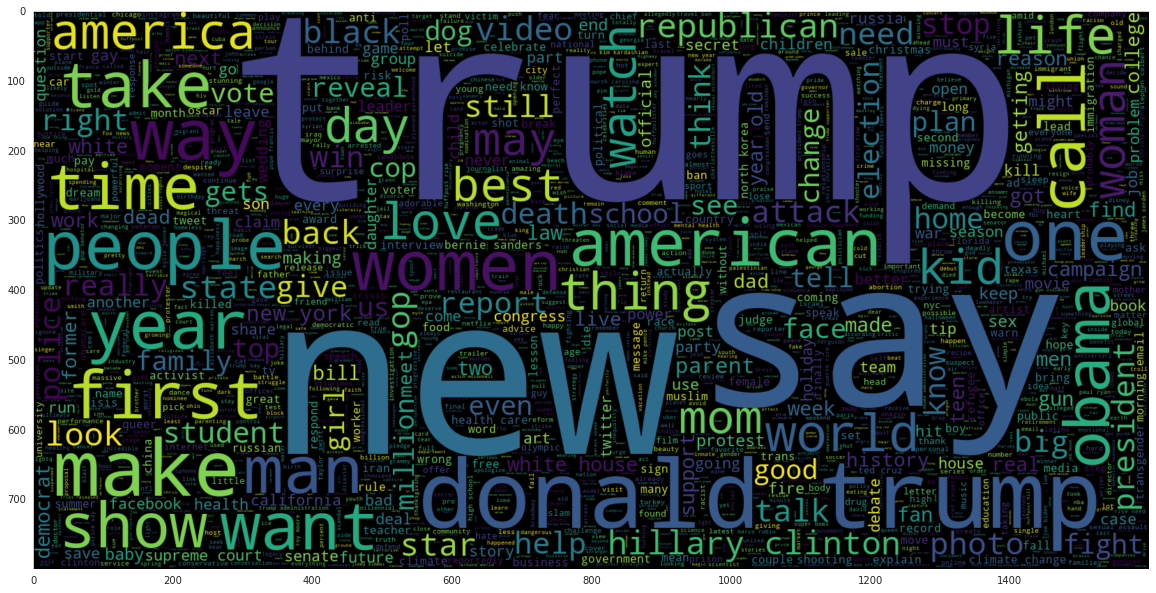

In [12]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

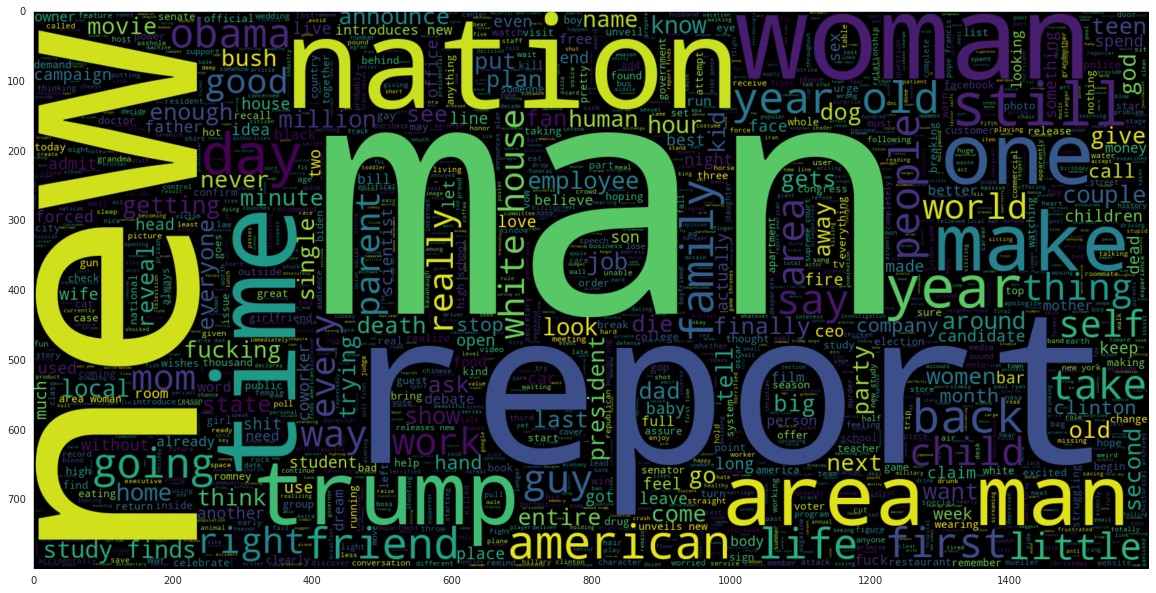

In [13]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

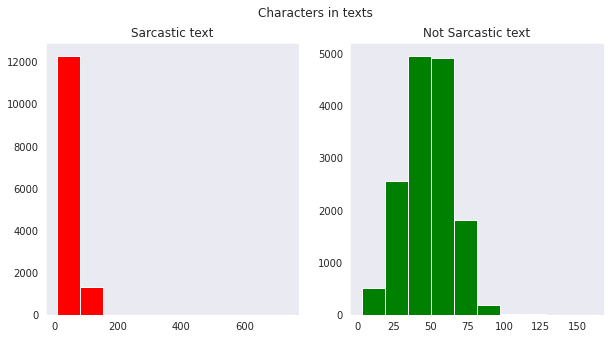

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

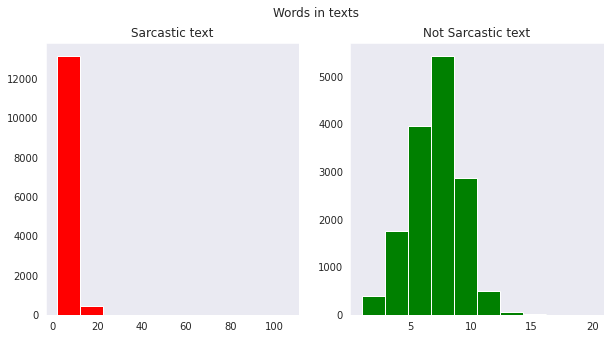

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

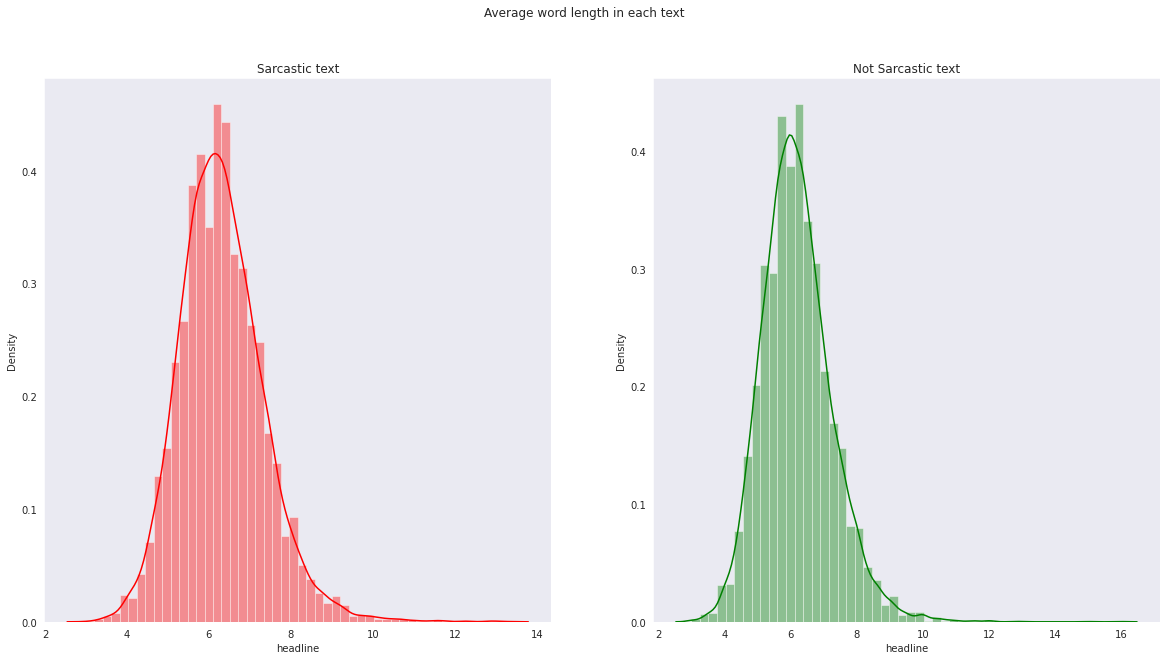

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [19]:
labels=np.array(df.is_sarcastic)
len(np.unique(labels))

2

In [21]:
tf=Tokenizer(num_words=1000,oov_token="oov<>")
tf.fit_on_texts(df.headline)

In [22]:
a=tf.word_index
a["oov<>"]

1

In [24]:
seq=tf.texts_to_sequences(df.headline)
seq[:5]

[[1, 261, 1, 1, 1, 554, 1],
 [1, 1, 651, 1, 152, 1, 948, 1, 1, 1],
 [759, 1, 173, 1, 542, 1],
 [1, 1, 1, 1, 74, 81],
 [369, 392, 230, 821, 466, 445, 1, 1]]

In [25]:
pad=pad_sequences(seq,maxlen=100,padding="post")

In [26]:
pad=np.array(pad)

In [27]:
pad

array([[  1, 261,   1, ...,   0,   0,   0],
       [  1,   1, 651, ...,   0,   0,   0],
       [759,   1, 173, ...,   0,   0,   0],
       ...,
       [523,   1, 242, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [133,   1, 171, ...,   0,   0,   0]], dtype=int32)

In [28]:
num_class=len(np.unique(labels))

In [29]:
xr,xt,yr,yt=train_test_split(pad,labels,test_size=0.1)

In [6]:
from keras.utils.np_utils import to_categorical
yr=keras.utils.to_categorical(yr,num_class)
yt=keras.utils.to_categorical(yt,num_class)

AttributeError: ignored